In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, mapping
from scipy.stats import ttest_ind
import json
import seaborn as sns

adata = sc.datasets.visium_sge()
adata.var_names_make_unique()

coords = adata.obsm["spatial"]

print(adata)


C:\Users\hp\AppData\Local\Temp\ipykernel_21472\3988108526.py:10: FutureWarning: Use `squidpy.datasets.visium` instead.
  adata = sc.datasets.visium_sge()
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\datasets\_datasets.py:555: FutureWarning: Use `squidpy.read.visium` instead.
  return read_visium(sample_dir, source_image_path=source_image_path)
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


C:\Users\hp\AppData\Local\Temp\ipykernel_21472\4149001864.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, size=1.3)


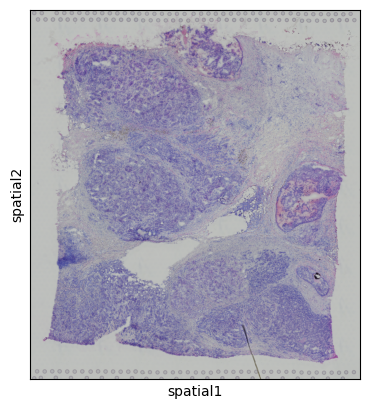

In [2]:
sc.pl.spatial(adata, size=1.3)


In [3]:
cx, cy = coords.mean(axis=0)
size = 1000

poly = Polygon([
    (cx - size, cy - size),
    (cx + size, cy - size),
    (cx + size, cy + size),
    (cx - size, cy + size),
])

inside = np.array([poly.contains(Point(x, y)) for x, y in coords])

print("Spots inside ROI:", inside.sum())
print("Spots outside ROI:", (~inside).sum())


Spots inside ROI: 68
Spots outside ROI: 3730


C:\Users\hp\AppData\Local\Temp\ipykernel_21472\2240833023.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  axs = sc.pl.spatial(adata, size=1.3, show=False)


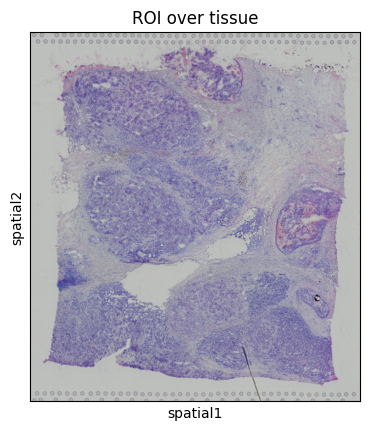

In [5]:
axs = sc.pl.spatial(adata, size=1.3, show=False)

# Get the first axis from the list
ax = axs[0]

x, y = poly.exterior.xy
ax.plot(x, y, color="red", linewidth=2)

plt.title("ROI over tissue")
plt.show()


In [6]:
gene_sums = np.array(adata.X.sum(axis=0)).ravel()
genes_expressed = adata.var_names[gene_sums > 0]

print("Expressed genes:", len(genes_expressed))
genes_expressed[:10]


Expressed genes: 24923


Index(['AL627309.1', 'AL627309.5', 'AP006222.2', 'AL669831.2', 'LINC01409',
       'FAM87B', 'LINC01128', 'LINC00115', 'FAM41C', 'AL645608.6'],
      dtype='object')

In [7]:
results = []

for gene in genes_expressed[:500]:
    inside_vals = adata[inside, gene].X
    outside_vals = adata[~inside, gene].X

    if hasattr(inside_vals, "toarray"):
        inside_vals = inside_vals.toarray()
    if hasattr(outside_vals, "toarray"):
        outside_vals = outside_vals.toarray()

    inside_vals = np.asarray(inside_vals, float).ravel()
    outside_vals = np.asarray(outside_vals, float).ravel()

    if len(inside_vals) == 0 or len(outside_vals) == 0:
        continue
    if inside_vals.var() == 0 and outside_vals.var() == 0:
        continue

    tstat, pval = ttest_ind(inside_vals, outside_vals, equal_var=False)

    results.append({
        "gene": gene,
        "inside_mean": inside_vals.mean(),
        "outside_mean": outside_vals.mean(),
        "log2FC": np.log2((inside_vals.mean()+1e-6)/(outside_vals.mean()+1e-6)),
        "pval": pval
    })

df = pd.DataFrame(results).sort_values("pval")
df.head(10)


,gene,inside_mean,outside_mean,log2FC,pval
176,MIR34AHG,0.0,0.069169,-16.077857,4.540486e-53
279,CPLANE2,0.0,0.051743,-15.659094,1.344745e-41
87,AL513477.2,0.0,0.041287,-15.333430,4.881701e-32
260,SLC25A34,0.0,0.031903,-14.961472,7.878392e-27
407,NCMAP,0.0,0.018231,-14.154151,1.085746e-14
186,PIK3CD-AS2,0.0,0.017694,-14.111084,2.995379e-14
71,AL109917.1,0.0,0.013405,-13.710572,1.307507e-12
469,CD164L2,0.0,0.011528,-13.492999,4.860930e-11
306,ACTL8,0.0,0.010724,-13.388671,6.142227e-10
405,RCAN3AS,0.0,0.010724,-13.388671,6.142227e-10


In [8]:
from statsmodels.stats.multitest import multipletests

df["fdr"] = multipletests(df["pval"], method="fdr_bh")[1]
df.head(10)


,gene,inside_mean,outside_mean,log2FC,pval,fdr
176,MIR34AHG,0.0,0.069169,-16.077857,4.540486e-53,2.270243e-50
279,CPLANE2,0.0,0.051743,-15.659094,1.344745e-41,3.361862e-39
87,AL513477.2,0.0,0.041287,-15.333430,4.881701e-32,8.136168e-30
260,SLC25A34,0.0,0.031903,-14.961472,7.878392e-27,9.847990e-25
407,NCMAP,0.0,0.018231,-14.154151,1.085746e-14,1.085746e-12
186,PIK3CD-AS2,0.0,0.017694,-14.111084,2.995379e-14,2.496149e-12
71,AL109917.1,0.0,0.013405,-13.710572,1.307507e-12,9.339338e-11
469,CD164L2,0.0,0.011528,-13.492999,4.860930e-11,3.038081e-09
306,ACTL8,0.0,0.010724,-13.388671,6.142227e-10,3.071113e-08
405,RCAN3AS,0.0,0.010724,-13.388671,6.142227e-10,3.071113e-08


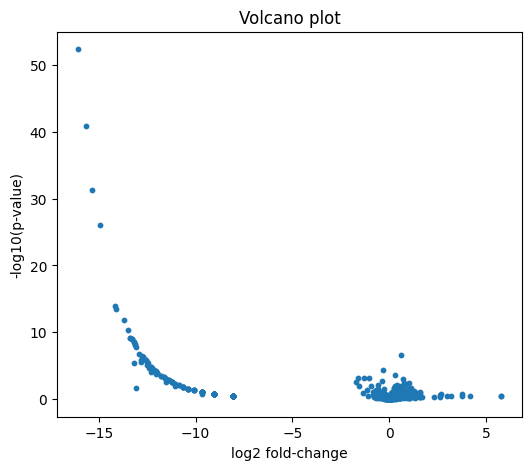

In [9]:
plt.figure(figsize=(6,5))
plt.scatter(df["log2FC"], -np.log10(df["pval"]), s=10)
plt.xlabel("log2 fold-change")
plt.ylabel("-log10(p-value)")
plt.title("Volcano plot")
plt.show()


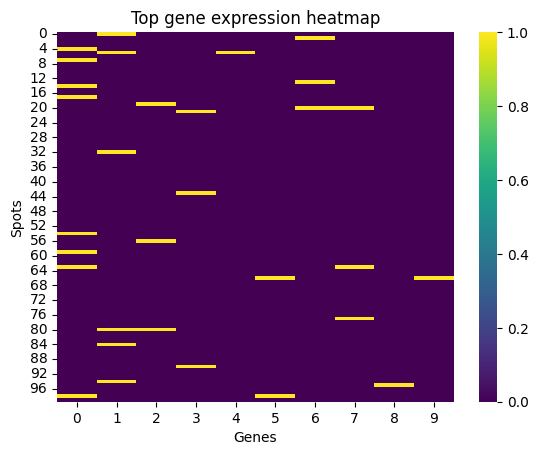

In [10]:
top_genes = df["gene"].head(10).tolist()

sub = adata[:, top_genes].X
if hasattr(sub, "toarray"):
    sub = sub.toarray()

sns.heatmap(sub[:100, :], cmap="viridis")
plt.xlabel("Genes")
plt.ylabel("Spots")
plt.title("Top gene expression heatmap")
plt.show()


In [11]:
poly2 = Polygon([
    (cx + 500, cy + 500),
    (cx + 1500, cy + 500),
    (cx + 1500, cy + 1500),
    (cx + 500, cy + 1500),
])

inside2 = np.array([poly2.contains(Point(x, y)) for x, y in coords])

print("ROI1:", inside.sum(), "ROI2:", inside2.sum())


ROI1: 68 ROI2: 11


In [12]:
geojson = {
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {"name": "ROI1"}, "geometry": mapping(poly)},
        {"type": "Feature", "properties": {"name": "ROI2"}, "geometry": mapping(poly2)}
    ]
}

with open("rois.geojson", "w") as f:
    json.dump(geojson, f, indent=2)

print("Saved rois.geojson")


Saved rois.geojson


In [14]:
import napari

viewer = napari.Viewer()
viewer.add_points(coords, size=5, name="spots")
viewer.add_shapes([np.array(poly.exterior.coords)], shape_type="polygon", edge_color="red", name="ROI1")
viewer.add_shapes([np.array(poly2.exterior.coords)], shape_type="polygon", edge_color="blue", name="ROI2")


<Shapes layer 'ROI2' at 0x210264b7910>